In [1]:
!pip install datasets
!pip install transformers pandas tqdm scikit-learn datasets
!pip install tf-keras
!pip install seaborn
!pip install transformers[torch]

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
zsh:1: no matches found: transformers[torch]


In [6]:
# 导包
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from datasets import Dataset
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# 3. 数据读取
data = pd.read_csv('fakenews.csv')  # 读取上传的文件

# 将数据分为训练集、验证集和测试集
train_data = data.sample(frac=0.7, random_state=42)  # 70%训练集
remaining_data = data.drop(train_data.index)
val_data = remaining_data.sample(frac=0.5, random_state=42)  # 15%验证集
test_data = remaining_data.drop(val_data.index)              # 15%测试集

# 将Pandas DataFrame转换为Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# 4. 预处理
# 加载BERT的tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 定义tokenize函数
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# 对数据集进行tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# 设置数据格式为PyTorch Tensor
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# 5. 加载预训练模型
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# 6. 定义训练参数
training_args = TrainingArguments(
    output_dir="./results",          # 输出目录
    num_train_epochs=3,             # 训练轮数
    per_device_train_batch_size=8,  # 训练批次大小
    per_device_eval_batch_size=8,   # 验证批次大小
    logging_dir="./logs",            # 日志目录
    logging_steps=10,               # 每10步记录一次日志
    evaluation_strategy="epoch",    # 每个epoch进行一次验证
    save_strategy="epoch",          # 每个epoch保存一次模型
    save_total_limit=2,             # 最多保存2个模型
    load_best_model_at_end=True,    # 训练结束时加载最佳模型
    report_to="none",               # 禁用 W&B
)

# 7. 定义评估函数
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
        "f1": f1_score(labels, predictions),
    }

# 8. 定义Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # 使用验证集进行评估
    compute_metrics=compute_metrics,
)

# 9. 微调模型
trainer.train()

# 10. 保存微调后的模型
trainer.save_model("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")

# 11. 加载微调后的模型
model = BertForSequenceClassification.from_pretrained("./fine_tuned_bert")
tokenizer = BertTokenizer.from_pretrained("./fine_tuned_bert")

# 12. 在测试集上评估模型
# 定义推理函数
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    return torch.argmax(logits, dim=-1).item(), torch.softmax(logits, dim=-1)[0][1].item()  # 返回类别和概率

# 批量推理
predictions = []
probabilities = []
true_labels = test_dataset["label"]
input_texts = test_dataset["text"]

for text in tqdm(input_texts[:100]):
    predicted_label, predicted_prob = predict(text)
    predictions.append(predicted_label)
    probabilities.append(predicted_prob)

results_df = pd.DataFrame({
    "Input Text": input_texts[:100],
    "True Label": true_labels[:100],
    "Predicted Label": predictions,
    "Predicted Probability": probabilities
})
print(results_df)


Map: 100%|██████████| 748/748 [00:08<00:00, 89.30 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/environment/miniconda3/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.560500,0.497155,0.771390,0.802419,0.619938,0.699473
2,0.420300,0.531731,0.784759,0.775862,0.700935,0.736498
3,0.277800,0.787317,0.794118,0.795053,0.700935,0.745033


100%|██████████| 100/100 [00:14<00:00,  7.00it/s]

                                           Input Text  True Label  \
0   It’s safe to say that Instagram Stories has fa...           0   
1   Much like a certain Amazon goddess with a lass...           0   
2   Scott Disick is sticking up for Khloe Kardashi...           1   
3   It wouldn't be a holiday without a Kardashian ...           0   
4   President Trump decided to go ahead and do wha...           1   
..                                                ...         ...   
95  There's no other show that knows how to delive...           0   
96  Nikki Reed and Nina Dobrev have always gotten ...           1   
97  Best Director: “Manchester by the Sea”  “I thi...           1   
98  Jordin Sparks isn't a regular mom, she's a god...           0   
99  The Connecticut native, who is currently a res...           0   

    Predicted Label  Predicted Probability  
0                 0               0.135022  
1                 0               0.440559  
2                 0               0.

TypeError: only integer tensors of a single element can be converted to an index

/tmp/ipykernel_1411/3203962172.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracy_per_class.keys()), y=list(accuracy_per_class.values()), palette="viridis")


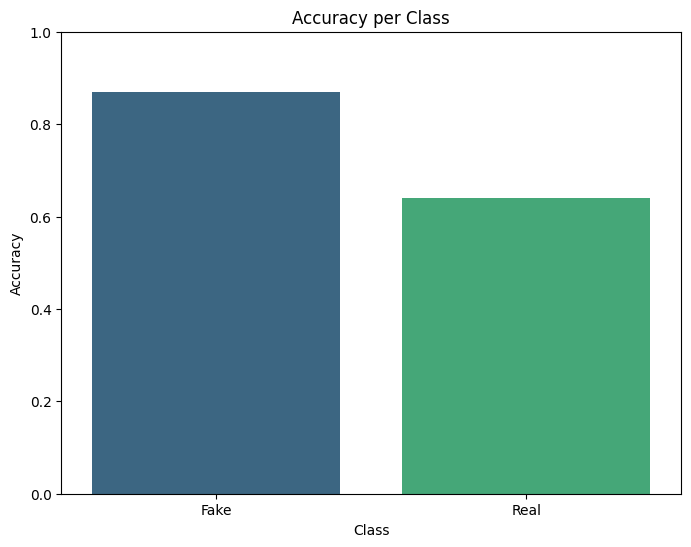

In [ ]:
import numpy as np

# 确保 predictions 和 true_labels 是 NumPy 数组
predictions = np.array(predictions)
true_labels = np.array(true_labels[:100])

# 计算每个类别的准确率
accuracy_per_class = {
    "Fake": accuracy_score(true_labels[true_labels == 0], predictions[true_labels == 0]),
    "Real": accuracy_score(true_labels[true_labels == 1], predictions[true_labels == 1])
}

# 绘制条形图（预测100个带标签的新闻例子）
plt.figure(figsize=(8, 6))
sns.barplot(x=list(accuracy_per_class.keys()), y=list(accuracy_per_class.values()), palette="viridis")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Accuracy per Class")
plt.ylim(0, 1)  # 设置y轴范围为0到1
plt.show()

Map: 100%|██████████| 748/748 [00:08<00:00, 86.56 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/environment/miniconda3/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/environment/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.172000,0.170126,0.526738
2,0.125600,0.166116,0.528075
3,0.059300,0.184686,0.471925


/environment/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/environment/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/environment/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have

Test Accuracy: 0.5481


ValueError: x and y must have same first dimension, but have shapes (131,) and (3,)

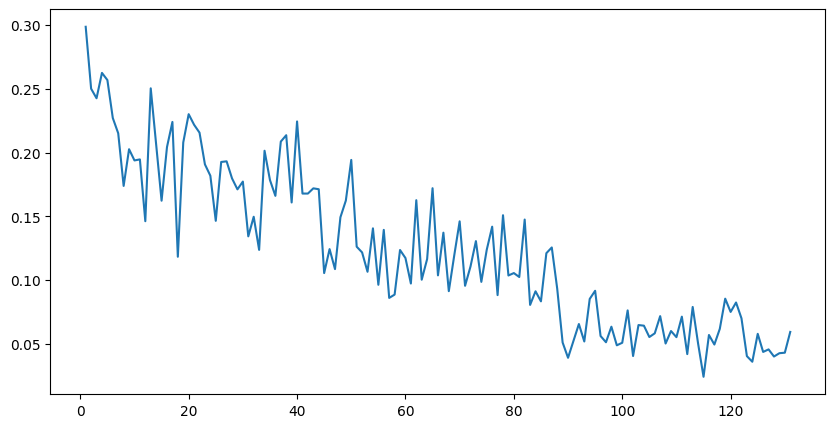

In [8]:

# 自定义 MSE 损失
class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, outputs, labels):
        logits = outputs.logits
        return self.mse_loss(logits, labels.unsqueeze(1).float())



# 1. 加载预训练模型
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# 2. 定义训练参数
training_args = TrainingArguments(
    output_dir="./results",          # 输出目录
    num_train_epochs=3,             # 训练轮数
    per_device_train_batch_size=8,  # 训练批次大小
    per_device_eval_batch_size=8,   # 验证批次大小
    logging_dir="./logs",            # 日志目录
    logging_steps=10,               # 每10步记录一次日志
    evaluation_strategy="epoch",    # 每个epoch进行一次验证
    save_strategy="epoch",          # 每个epoch保存一次模型
    save_total_limit=2,             # 最多保存2个模型
    load_best_model_at_end=True,    # 训练结束时加载最佳模型
    report_to="none",               # 禁用 W&B
)

# 3. 定义评估函数
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    return {
        "accuracy": accuracy_score(labels, predictions),
    }

# 4. 定义自定义Trainer
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = CustomMSELoss()

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        loss = self.loss_fn(outputs, labels)
        return (loss, outputs) if return_outputs else loss

# 5. 定义Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # 使用验证集进行评估
    compute_metrics=compute_metrics,
)

# 6. 微调模型
trainer.train()

# 7. 保存微调后的模型
trainer.save_model("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")

# 8. 加载微调后的模型
model = BertForSequenceClassification.from_pretrained("./fine_tuned_bert")
tokenizer = BertTokenizer.from_pretrained("./fine_tuned_bert")

# 9. 在测试集上评估模型
# 定义推理函数
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    return torch.argmax(logits, dim=-1).item(), torch.softmax(logits, dim=-1)[0][1].item()  # 返回类别和概率

# 批量推理
predictions = []
probabilities = []
true_labels = test_dataset["label"]
input_texts = test_dataset["text"]

for text in tqdm(input_texts):  
    predicted_label, predicted_prob = predict(text)
    predictions.append(predicted_label)
    probabilities.append(predicted_prob)

# 计算评估指标
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")



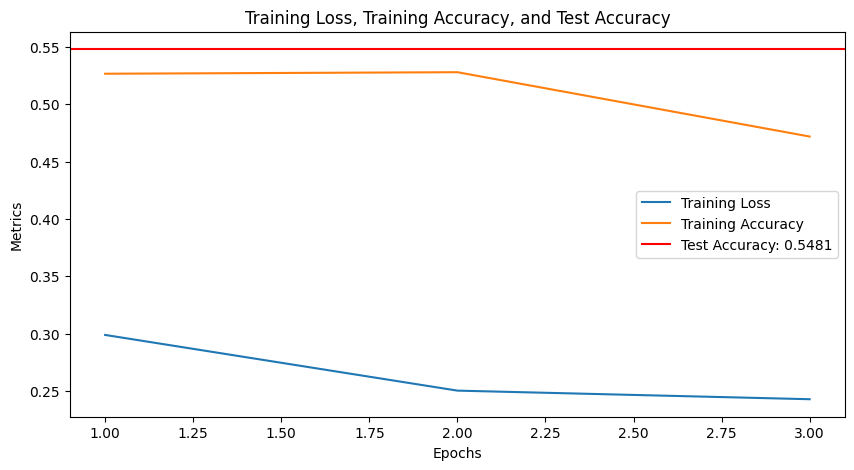

In [ ]:
# 10. 绘制训练损失、训练准确率和测试准确率图表（使用MSE-loss函数）
train_losses = []
train_accuracies = []
for log in trainer.state.log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])
    if 'eval_accuracy' in log:
        train_accuracies.append(log['eval_accuracy'])

# 确保 train_losses 和 train_accuracies 长度一致
min_len = min(len(train_losses), len(train_accuracies))
train_losses = train_losses[:min_len]
train_accuracies = train_accuracies[:min_len]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.axhline(y=accuracy, color='r', linestyle='-', label=f"Test Accuracy: {accuracy:.4f}")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Training Loss, Training Accuracy, and Test Accuracy")
plt.legend()
plt.show()

Map: 100%|██████████| 748/748 [00:08<00:00, 87.89 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/environment/miniconda3/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.526000,0.495228,0.766043,0.782946,0.629283,0.697755
2,0.423800,0.608089,0.775401,0.732523,0.750779,0.741538
3,0.204700,0.862839,0.772727,0.752508,0.700935,0.725806


100%|██████████| 748/748 [01:45<00:00,  7.09it/s]

Test Accuracy: 0.7620


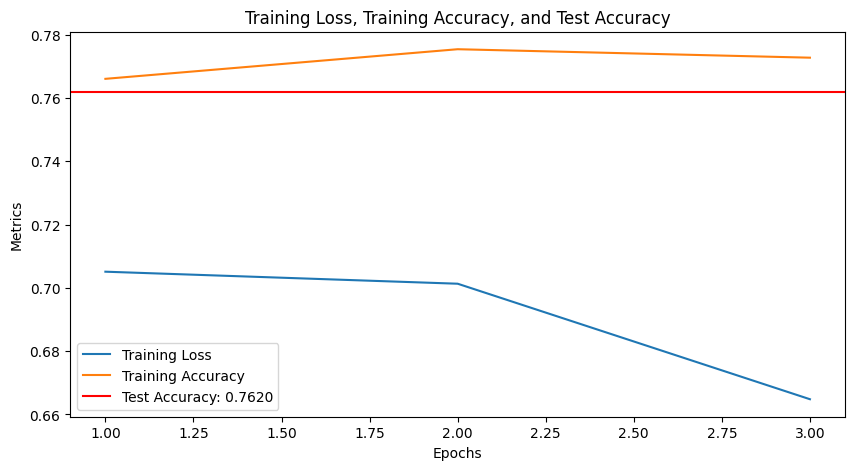

In [ ]:


# 将数据分为训练集、验证集和测试集
train_data = data.sample(frac=0.7, random_state=42)  # 70%训练集
remaining_data = data.drop(train_data.index)
val_data = remaining_data.sample(frac=0.5, random_state=42)  # 15%验证集
test_data = remaining_data.drop(val_data.index)              # 15%测试集

# 将Pandas DataFrame转换为Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# 4. 预处理
# 加载BERT的tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 定义tokenize函数
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# 对数据集进行tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# 设置数据格式为PyTorch Tensor
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# 5. 加载预训练模型
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# 6. 定义训练参数
training_args = TrainingArguments(
    output_dir="./results",          # 输出目录
    num_train_epochs=3,             # 训练轮数
    per_device_train_batch_size=8,  # 训练批次大小
    per_device_eval_batch_size=8,   # 验证批次大小
    logging_dir="./logs",            # 日志目录
    logging_steps=10,               # 每10步记录一次日志
    evaluation_strategy="epoch",    # 每个epoch进行一次验证
    save_strategy="epoch",          # 每个epoch保存一次模型
    save_total_limit=2,             # 最多保存2个模型
    load_best_model_at_end=True,    # 训练结束时加载最佳模型
    report_to="none",               # 禁用 W&B
)

# 7. 定义评估函数
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
        "f1": f1_score(labels, predictions),
    }


class CustomCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
        self.eval_accuracy = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        # 记录训练损失
        if "loss" in logs and "eval_loss" not in logs:
            self.train_loss.append(logs["loss"])
        # 记录评估损失和准确率
        if "eval_loss" in logs:
            self.eval_loss.append(logs["eval_loss"])
            self.eval_accuracy.append(logs["eval_accuracy"])

# 初始化回调函数
custom_callback = CustomCallback()
# 8. 定义Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2), custom_callback],  # 添加自定义回调
)

# 9. 微调模型
trainer.train()
# 10. 保存微调后的模型
trainer.save_model("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")

# 11. 加载微调后的模型
model = BertForSequenceClassification.from_pretrained("./fine_tuned_bert")
tokenizer = BertTokenizer.from_pretrained("./fine_tuned_bert")

# 12. 在测试集上评估模型
# 定义推理函数
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    return torch.argmax(logits, dim=-1).item(), torch.softmax(logits, dim=-1)[0][1].item()  # 返回类别和概率

# 批量推理
predictions = []
probabilities = []
true_labels = test_dataset["label"]
input_texts = test_dataset["text"]

for text in tqdm(input_texts):  
    predicted_label, predicted_prob = predict(text)
    predictions.append(predicted_label)
    probabilities.append(predicted_prob)

# 计算评估指标
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# 绘制训练曲线（使用callback方法抑制过拟合）
train_losses = []
train_accuracies = []
for log in trainer.state.log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])
    if 'eval_accuracy' in log:
        train_accuracies.append(log['eval_accuracy'])

# 确保 train_losses 和 train_accuracies 长度一致
min_len = min(len(train_losses), len(train_accuracies))
train_losses = train_losses[:min_len]
train_accuracies = train_accuracies[:min_len]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.axhline(y=accuracy, color='r', linestyle='-', label=f"Test Accuracy: {accuracy:.4f}")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Training Loss, Training Accuracy, and Test Accuracy")
plt.legend()
plt.show()